<a href="https://colab.research.google.com/github/jsblandon/sdm_py/blob/main/sdm_co_gh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Instalación de paquetes**

In [ ]:
%%capture

# Retrieving tile maps from the internet
!pip3 install contextily

# geospatial xarray extension powered by rasterio
!pip install rioxarray

# Utilities for applying scikit-learn to spatial datasets
!pip install pyimpute

# Plot data on map projections with matplotlib
!python -m pip install basemap

# A Python library for making geographic flat-top hexagon grids like QGIS's `create grid` function
!pip install geohexgrid

# Artist for matplotlib to display a scale bar
!pip install matplotlib-scalebar

In [ ]:
# Se importan funciones auxiliares desde GitHub requeridas para el desarrollo de
# este práctico
!git clone https://github.com/jsblandon/weather_data_uy_preprocessing.git
import sys
sys.path.append('/content/weather_data_uy_preprocessing')

Cloning into 'weather_data_uy_preprocessing'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 22 (delta 9), reused 3 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 20.27 KiB | 10.13 MiB/s, done.
Resolving deltas: 100% (9/9), done.


## **Carga de Librerías**

In [ ]:
import os                          # directory managing
from glob import glob              # files managing
import contextily as cx            # basemap tiles
import geopandas as gpd            # shapefile managing
import matplotlib.colors as colors # customize colors
import matplotlib.pyplot as plt    # plots
import matplotlib.font_manager as fm # custom fonts
import numpy as np                 # array managing
import pandas as pd                # structured data managing
import xarray as xr                # labelled multi-dimensional arrays
import rasterio as rio             # rastewr managing
import rioxarray as rxr            # raster managing
import seaborn as sns              # plots
from geopandas import GeoDataFrame
from matplotlib.colors import ListedColormap
from matplotlib_scalebar.scalebar import ScaleBar                               # Barra de escala en gráficos
from mpl_toolkits.axes_grid1 import make_axes_locatable
from natsort import natsorted      # natural sorting strings
from urllib.request import urlopen # requests managing
from io import BytesIO             # file managing
from pandas import DataFrame       # pandas dataframe structure
from rasterio.plot import show     # plotting from rasterio
from matplotlib import colors, patches
from shapely.geometry import mapping, Point, Polygon # for clipping rasters using shapes and geometries managing
from shapely import geometry       # geomtric operations and managing
from tqdm import tqdm              # Progress tracking
from urllib.error import HTTPError # Error handler
from warnings import simplefilter  # get rid off warnings
from weather_data_preprocessing import null_report
from zipfile import ZipFile        # .zip files managing


# ML STAGE PACKAGES
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder # to encode categotrical data
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [ ]:
# Plot settings
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

sns.set_style('whitegrid')
simplefilter("ignore")

## **Carga de Funciones**

In [ ]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    f""" Funcion para guardar figuras eficientemente

        Recibe
        ------
        fig_id : string
            Identificador de la figura

        Devuelve
        --------
        Figura almacenada en el directorio de trabajo

        Fuente: Géron, A. (2022). Hands-on machine learning with Scikit-Learn,
        Keras, and TensorFlow. " O'Reilly Media, Inc.".

    """
    path =  f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution,bbox_inches="tight",transparent=True)

## **Carga de Datos**

In [ ]:
# Se cargan los datos del GeoDataFrame
path = "ruta/shape/avistamientos/variables/unidas"
gdf_mb_ev_elv_wc_cr = gpd.read_file(path)

In [ ]:
# Se cargan las descripciones de MapBiomas Colombia
path = 'ruta/leyendas/mapbiomas'
df_mb_legends = pd.read_csv(path, delimiter=';')

In [ ]:
# Se renombran las variables
keys = gdf_mb_ev_elv_wc_cr.columns.to_list()
values = ['cell_id','observation_count', 'effort_speed_kmph','effort_hours',
          'effort_distance_km','number_observers', 'label','elevation',
          'anual_mean_t', 'mean_diurnal_range','isothermality', 't_seasonality',
          'max_t_warmest_month', 'min_t_coldest_month', 't_annual_range',
          'mean_t_wettest_q', 'mean_t_driest_q','mean_t_warmest_q','mean_t_coldest_q',
          'annual_p', 'p_wettest_m','p_driest_m', 'p_seasonality', 'p_wettest_q',
          'p_driest_q', 'p_warmest_q', 'p_coldest_q','index_right', 'lulc_2014',
          'lulc_2015', 'lulc_2016', 'lulc_2017', 'lulc_2018', 'lulc_2019',
          'lulc_2020', 'geometry']

gdf_mb_ev_elv_wc_cr.rename(columns=dict(zip(keys, values)),inplace=True)

In [ ]:
# Se convierten las columnas que tomaron los datos como cadenas de caracteres a
# números
columnas_strings = ['elevation','anual_mean_t', 'mean_diurnal_range','isothermality',
                    't_seasonality', 'max_t_warmest_month', 'min_t_coldest_month',
                    't_annual_range', 'mean_t_wettest_q', 'mean_t_driest_q',
                    'mean_t_warmest_q','mean_t_coldest_q','annual_p', 'p_wettest_m',
                    'p_driest_m', 'p_seasonality', 'p_wettest_q','p_driest_q',
                    'p_warmest_q', 'p_coldest_q']

gdf_mb_ev_elv_wc_cr[columnas_strings] = gdf_mb_ev_elv_wc_cr[columnas_strings].astype(float)

# Se convierten las columnas de MapBiomas a enteros
columnas_ints = ['lulc_2014', 'lulc_2015', 'lulc_2016', 'lulc_2017', 'lulc_2018',
                 'lulc_2019', 'lulc_2020']

gdf_mb_ev_elv_wc_cr[columnas_ints] = gdf_mb_ev_elv_wc_cr[columnas_ints].astype(int)

In [ ]:
df_mb_legends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   clases  26 non-null     object
 1   id      26 non-null     int64 
 2   hex     26 non-null     object
dtypes: int64(1), object(2)
memory usage: 752.0+ bytes


In [ ]:
# Las variables de uso y cobertura de suelo son categóricas, por lo que conviene
# convertirlas a cadenas de texto y luego generar la codificación dummy. Primero
# a cadena de texto:
lulc_list = ['lulc_2014', 'lulc_2015', 'lulc_2016', 'lulc_2017', 'lulc_2018',
             'lulc_2019', 'lulc_2020']

for lulc_year in lulc_list:
    keys = list(gdf_mb_ev_elv_wc_cr[lulc_year].unique())
    values = df_mb_legends[df_mb_legends['id'].isin(keys)]['clases']
    gdf_mb_ev_elv_wc_cr[lulc_year].replace(dict(zip(keys,values)), inplace=True)

gdf_mb_ev_elv_wc_cr

cell_id  observation_count  effort_speed_kmph  effort_hours  \
0     -2098,24366                0.0              0.000           0.0   
1     -2098,24374                0.0              0.000           0.0   
2     -2098,24376                0.0              0.000           0.0   
3     -2098,24378                0.0              0.000           0.0   
4     -2098,24380                0.0              0.000           0.0   
...           ...                ...                ...           ...   
6480  -2224,24542                0.0              1.575           6.4   
6481  -2224,24544                0.0              0.000           0.0   
6482  -2224,24546                0.0              0.000           0.0   
6483  -2225,24539                0.0              0.000           0.0   
6484  -2225,24541                0.0              0.000           0.0   

      effort_distance_km  number_observers  label  elevation  anual_mean_t  \
0                   0.00               0.0      0     4294.0      3.497833   
1                   0.00               0.0      0     4249.0      3.748000   
2                   0.00               0.0      0     4249.0      3.748000   
3                   0.00               0.0      0     4249.0      3.748000   
4                   0.00               0.0      0     4249.0      3.748000   
...                  ...               ...    ...        ...           ...   
6480                4.13              15.0      0      435.0     25.054001   
6481                0.00               0.0      0      435.0     25.054001   
6482                0.00               0.0      0      435.0     25.054001   
6483                0.00               0.0      0      435.0     25.054001   
6484                0.00               0.0      0      435.0     25.054001   

      mean_diurnal_range  ...  p_coldest_q  index_right  \
0               8.543000  ...        268.0            0   
1               8.762667  ...        279.0            1   
2               8.762667  ...        279.0            2   
3               8.762667  ...        279.0            3   
4               8.762667  ...        279.0            4   
...                  ...  ...          ...          ...   
6480            9.688666  ...       1175.0         6481   
6481            9.688666  ...       1175.0         6482   
6482            9.688666  ...       1175.0         6483   
6483            9.688666  ...       1175.0         6484   
6484            9.688666  ...       1175.0         6485   

                         lulc_2014                     lulc_2015  \
0                           bosque                        bosque   
1                           bosque                        bosque   
2              afloramiento_rocoso           afloramiento_rocoso   
3              afloramiento_rocoso           afloramiento_rocoso   
4              afloramiento_rocoso           afloramiento_rocoso   
...                            ...                           ...   
6480  mosaico_de_agricultura_pasto  mosaico_de_agricultura_pasto   
6481                       mineria                       mineria   
6482                       mineria                       mineria   
6483                       mineria                       mineria   
6484                       mineria                       mineria   

                         lulc_2016                 lulc_2017  \
0                           bosque                    bosque   
1                           bosque       afloramiento_rocoso   
2              afloramiento_rocoso                    bosque   
3              afloramiento_rocoso                    bosque   
4                           bosque                    bosque   
...                            ...                       ...   
6480  mosaico_de_agricultura_pasto                   mineria   
6481                       mineria  otra_area_sin_vegetacion   
6482                       mineria  otra_area_sin_vegetacion   
6483                       min

In [ ]:
# Ahora los dummy para cada categoría de uso de suelo por año
gdf_mb_ev_elv_wc_cr = pd.concat([
    gdf_mb_ev_elv_wc_cr.drop(columns = lulc_list),
    pd.get_dummies(gdf_mb_ev_elv_wc_cr[lulc_list], dtype=float)
], axis = 1)

gdf_mb_ev_elv_wc_cr.head()

cell_id  observation_count  effort_speed_kmph  effort_hours  \
0  -2098,24366                0.0                0.0           0.0   
1  -2098,24374                0.0                0.0           0.0   
2  -2098,24376                0.0                0.0           0.0   
3  -2098,24378                0.0                0.0           0.0   
4  -2098,24380                0.0                0.0           0.0   

   effort_distance_km  number_observers  label  elevation  anual_mean_t  \
0                 0.0               0.0      0     4294.0      3.497833   
1                 0.0               0.0      0     4249.0      3.748000   
2                 0.0               0.0      0     4249.0      3.748000   
3                 0.0               0.0      0     4249.0      3.748000   
4                 0.0               0.0      0     4249.0      3.748000   

   mean_diurnal_range  ...  lulc_2019_otra_formacion_natural_no_forestal  \
0            8.543000  ...                                           0.0   
1            8.762667  ...                                           0.0   
2            8.762667  ...                                           0.0   
3            8.762667  ...                                           0.0   
4            8.762667  ...                                           0.0   

   lulc_2019_rio_lago_oceano  lulc_2020_afloramiento_rocoso  lulc_2020_bosque  \
0                        0.0                            0.0               1.0   
1                        0.0                            1.0               0.0   
2                        0.0                            0.0               1.0   
3                        0.0                            0.0               1.0   
4                        0.0                            0.0               1.0   

   lulc_2020_infraestructura_urbana  lulc_2020_mineria  \
0                               0.0                0.0   
1                               0.0                0.0   
2                               0.0                0.0   
3                               0.0                0.0   
4                               0.0                0.0   

   lulc_2020_mosaico_de_agricultura_pasto  lulc_2020_otra_area_sin_vegetacion  \
0                                     0.0                                 0.0   
1                                     0.0                                 0.0   
2                                     0.0                                 0.0   
3                                     0.0                                 0.0   
4                                     0.0                                 0.0   

   lulc_2020_otra_formacion_natural_no_forestal  lulc_2020_rio_lago_oceano  
0                                           0.0                        0.0  
1                                           0.0                        0.0  
2                                           0.0                        0.0  
3                                           0.0                        0.0  
4                                           0.0                        0.0  

[5 rows x 90 columns]

In [ ]:
# Declaremos las columnas que son únicamente numéricas
columnas_no_interes = ['cell_id','label','index_right']
variables_exogenas = gdf_mb_ev_elv_wc_cr.drop(columns=columnas_no_interes).columns.to_list()

## **Código Principal**

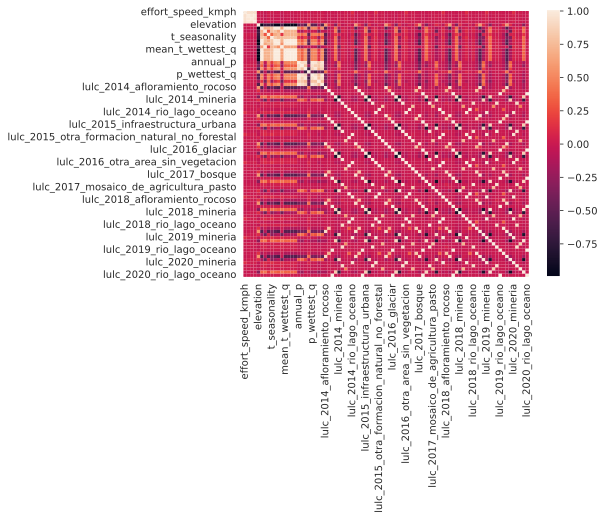

In [ ]:
# Matriz de correlación
sns.heatmap(gdf_mb_ev_elv_wc_cr[variables_exogenas].drop(columns=['geometry','observation_count']).corr(numeric_only=True))

# Displaying heatmap
plt.show()

In [ ]:
# Se declara la X e y de nuestro problema
X = gdf_mb_ev_elv_wc_cr[variables_exogenas]
y = gdf_mb_ev_elv_wc_cr['label']

In [ ]:
# Pipeline declaration
pipe_lr = Pipeline([('LR', LogisticRegression(random_state=42))])

In [ ]:
# Configuración de los hiper-parámetros del modelo
param_range_fl = [1.0, 0.5, 0.1]

lr_param_grid = [{'LR__penalty': ['l1', 'l2'],
                  'LR__C': param_range_fl,
                  'LR__solver': ['liblinear']}]

In [ ]:
# Configuración de validación cruzada

cv = 3
n_jobs = -1
verbose = 2
random_state = 42

lr_grid_search = RandomizedSearchCV(estimator=pipe_lr,
        param_distributions=lr_param_grid,
        scoring='accuracy',
        cv=cv,
        n_jobs = n_jobs,
        verbose=verbose,
        random_state=random_state)

### **Prueba sin tratar el desbalance de clases**

In [ ]:
# Particionamiento en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y,
                                                    test_size=0.20)

In [ ]:
%%time
# Randomized Search applied
grid_dict = {'Logistic Regression': lr_grid_search,
             }

for model, pipe in grid_dict.items():
    print('--------------------------------------------------------------')
    print('Model: ',model)
    pipe.fit(X_train.drop(columns=['geometry','observation_count']), y_train)
    print('Done')

--------------------------------------------------------------
Model:  Logistic Regression
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Done
CPU times: user 2.17 s, sys: 167 ms, total: 2.34 s
Wall time: 39.3 s


In [ ]:
# RESULTS
for model, pipe in grid_dict.items():

    print('-------------------------------------------------------------------\n')
    # Modelo final
    final_model = pipe.best_estimator_
    print('{} Best Params: {}\n'.format(model,pipe.best_params_))

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['geometry','observation_count']))

    # Medidas de desempeño para la clasificación del modelo
    print(classification_report(y_test, y_pred))

-------------------------------------------------------------------

Logistic Regression Best Params: {'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__C': 0.1}

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1293
           1       1.00      0.25      0.40         4

    accuracy                           1.00      1297
   macro avg       1.00      0.62      0.70      1297
weighted avg       1.00      1.00      1.00      1297



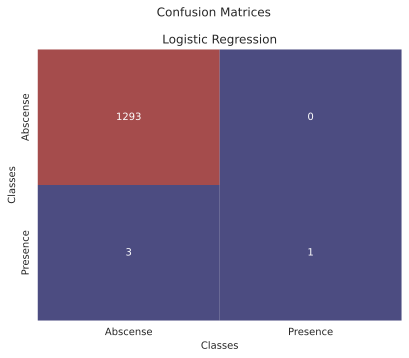

In [ ]:
# CONFUSION MATRICES
aux_grid_dict = {'Logistic Regression': lr_grid_search}

# Ancho de la columna del documento en pulgadas
ancho_columna = 6.5314961

# Relación de aspecto
aspect_ratio = (4/3)

# Altura de la figura
altura_figura = ancho_columna/aspect_ratio

# Crear figura y ejes
fig, axis = plt.subplots(1,1,figsize=(ancho_columna, altura_figura), sharex = True, sharey = True)
plt.suptitle("Confusion Matrices" , y = 1.0)

# Confusion matrices
for model, pipe in aux_grid_dict.items():

    # Final model
    final_model = pipe.best_estimator_

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['geometry','observation_count']))

    # Confusion matrices computation and plotting
    classes = ['Abscense', 'Presence']
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm.astype(int), columns=classes, index=classes)

    # Plotting
    plt.sca(axis)
    plt.title(model)
    sns.heatmap(df_cm, annot=True, cmap = 'seismic',cbar = False,fmt='g',alpha=0.7)
    axis.set_xlabel("Classes")
    axis.grid(False)

axis.set_ylabel("Classes")

# save_fig("confusion_matrices",fig_extension="svg")
# save_fig("confusion_matrices",fig_extension="png")
plt.show()

In [ ]:
# Se almacena la probabilidad de aparición de la especie en cada celda

# Modelo final
final_model = aux_grid_dict['Logistic Regression'].best_estimator_

# Estimación del modelo entrenado sobre todos los datos
y_final = final_model.predict_proba(X.drop(['geometry','observation_count'],axis=1))

# Almacenamiento de la probabilidad asociada al modelo
X['lr_probability'] = y_final[:,1]

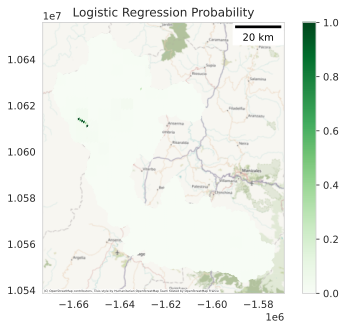

In [ ]:
# MAPS - PROBABILITY

# Ancho de la columna del documento en pulgadas
ancho_columna = 6.5314961

# Relación de aspecto
aspect_ratio = (4/3)

# Altura de la figura
altura_figura = ancho_columna/aspect_ratio

# Crear figura y ejes
fig, axis = plt.subplots(1,1,figsize=(ancho_columna, altura_figura), sharex = True, sharey = True)

axis.set_title('Logistic Regression Probability')
grafica = X.to_crs(epsg = 5382).plot(ax=axis, markersize=8, column='lr_probability', cmap=plt.cm.Greens , legend=True, vmin=0, vmax=1)
cx.add_basemap(ax=axis,crs=X.to_crs(epsg = 5382).crs,attribution_size=3)
axis.add_artist(ScaleBar(1))

plt.grid(False)

# save_fig("probability_lr",fig_extension="svg")
# save_fig("probability_lr",fig_extension="png")
plt.show()

### **Prueba balanceando clases: RandomOverSampler**

Los resultados anteriores pueden ser engañosos, por lo que convendría aplicar alguna técnica que permita lidiar con el desbalance de clases:

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [ ]:
# Conversión a GeoDataFrame
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)

In [ ]:
# Particionamiento en train/test a partir del oversampling
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.20)

In [ ]:
%%time
# Randomized Search applied
grid_dict = {'Logistic Regression': lr_grid_search,
             }

for model, pipe in grid_dict.items():
    print('--------------------------------------------------------------')
    print('Model: ',model)
    pipe.fit(X_train.drop(columns=['geometry','observation_count','lr_probability']), y_train)
    print('Done')

--------------------------------------------------------------
Model:  Logistic Regression
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Done
CPU times: user 47.8 s, sys: 1.1 s, total: 48.9 s
Wall time: 4min 37s


In [ ]:
# RESULTS
for model, pipe in grid_dict.items():

    print('-------------------------------------------------------------------\n')
    # Modelo final
    final_model = pipe.best_estimator_
    print('{} Best Params: {}\n'.format(model,pipe.best_params_))

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['geometry','observation_count','lr_probability']))

    # Medidas de desempeño para la clasificación del modelo
    print(classification_report(y_test, y_pred))

-------------------------------------------------------------------

Logistic Regression Best Params: {'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__C': 0.5}

              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1321
           1       0.95      1.00      0.97      1265

    accuracy                           0.97      2586
   macro avg       0.97      0.97      0.97      2586
weighted avg       0.97      0.97      0.97      2586



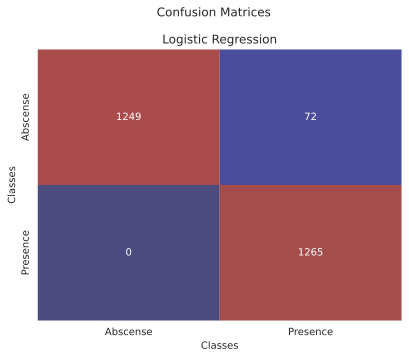

In [ ]:
# CONFUSION MATRICES
aux_grid_dict = {'Logistic Regression': lr_grid_search}

# Ancho de la columna del documento en pulgadas
ancho_columna = 6.5314961

# Relación de aspecto
aspect_ratio = (4/3)

# Altura de la figura
altura_figura = ancho_columna/aspect_ratio

# Crear figura y ejes
fig, axis = plt.subplots(1,1,figsize=(ancho_columna, altura_figura), sharex = True, sharey = True)
plt.suptitle("Confusion Matrices" , y = 1.0)

# Confusion matrices
for model, pipe in aux_grid_dict.items():

    # Final model
    final_model = pipe.best_estimator_

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['geometry','observation_count','lr_probability']))

    # Confusion matrices computation and plotting
    classes = ['Abscense', 'Presence']
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm.astype(int), columns=classes, index=classes)

    # Plotting
    plt.sca(axis)
    plt.title(model)
    sns.heatmap(df_cm, annot=True, cmap = 'seismic',cbar = False,fmt='g',alpha=0.7)
    axis.set_xlabel("Classes")
    axis.grid(False)

axis.set_ylabel("Classes")

# save_fig("confusion_matrices",fig_extension="svg")
# save_fig("confusion_matrices",fig_extension="png")
plt.show()

In [ ]:
# Se almacena la probabilidad de aparición de la especie en cada celda

# Modelo final
final_model = aux_grid_dict['Logistic Regression'].best_estimator_

# Estimación del modelo entrenado sobre todos los datos
y_final = final_model.predict_proba(X.drop(['geometry','observation_count','lr_probability'],axis=1))

# Almacenamiento de la probabilidad asociada al modelo
X['ros_probability'] = y_final[:,1]

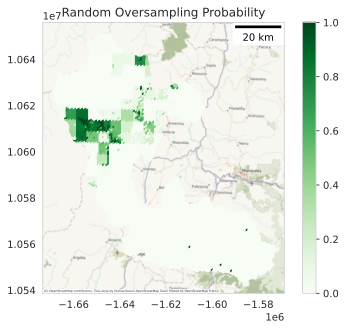

In [ ]:
# MAPS - PROBABILITY

# Ancho de la columna del documento en pulgadas
ancho_columna = 6.5314961

# Relación de aspecto
aspect_ratio = (4/3)

# Altura de la figura
altura_figura = ancho_columna/aspect_ratio

# Crear figura y ejes
fig, axis = plt.subplots(1,1,figsize=(ancho_columna, altura_figura), sharex = True, sharey = True)

axis.set_title('Random Oversampling Probability')
X.to_crs(epsg = 5382).plot(ax=axis, markersize=8, column='ros_probability', cmap='Greens', legend=True, vmin=0, vmax=1)
cx.add_basemap(ax=axis,crs=X.to_crs(epsg = 5382).crs,attribution_size=3)
axis.add_artist(ScaleBar(1))
plt.grid(False)

# save_fig("probability_lr",fig_extension="svg")
# save_fig("probability_lr",fig_extension="png")
plt.show()

### **Prueba balanceando clases: SMOTE - Synthetic Minority Over-sampling Technique**

Otra alternativa para tratar el desbalance es usar la función SMOTE:

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X.drop(columns=['geometry']), y)

In [ ]:
# Conversión a GeoDataFrame
X_resampled = pd.DataFrame(X_resampled, columns=X.drop(columns=['geometry']).columns)

In [ ]:
# Particionamiento en train/test a partir del oversampling
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.20)

In [ ]:
%%time
# Randomized Search applied
grid_dict = {'Logistic Regression': lr_grid_search,
             }

for model, pipe in grid_dict.items():
    print('--------------------------------------------------------------')
    print('Model: ',model)
    pipe.fit(X_train.drop(columns=['observation_count','lr_probability','ros_probability']), y_train)
    print('Done')

--------------------------------------------------------------
Model:  Logistic Regression
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Done
CPU times: user 54 s, sys: 893 ms, total: 54.9 s
Wall time: 4min 59s


In [ ]:
# RESULTS
for model, pipe in grid_dict.items():

    print('-------------------------------------------------------------------\n')
    # Modelo final
    final_model = pipe.best_estimator_
    print('{} Best Params: {}\n'.format(model,pipe.best_params_))

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['observation_count','lr_probability','ros_probability']))

    # Medidas de desempeño para la clasificación del modelo
    print(classification_report(y_test, y_pred))

-------------------------------------------------------------------

Logistic Regression Best Params: {'LR__solver': 'liblinear', 'LR__penalty': 'l1', 'LR__C': 1.0}

              precision    recall  f1-score   support

           0       1.00      0.95      0.98      1287
           1       0.96      1.00      0.98      1299

    accuracy                           0.98      2586
   macro avg       0.98      0.98      0.98      2586
weighted avg       0.98      0.98      0.98      2586



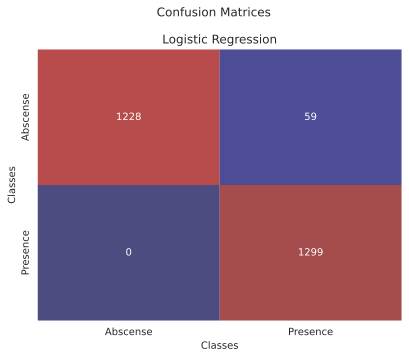

In [ ]:
# CONFUSION MATRICES
aux_grid_dict = {'Logistic Regression': lr_grid_search}

# Ancho de la columna del documento en pulgadas
ancho_columna = 6.5314961

# Relación de aspecto
aspect_ratio = (4/3)

# Altura de la figura
altura_figura = ancho_columna/aspect_ratio

# Crear figura y ejes
fig, axis = plt.subplots(1,1,figsize=(ancho_columna, altura_figura), sharex = True, sharey = True)
plt.suptitle("Confusion Matrices" , y = 1.0)

# Confusion matrices
for model, pipe in aux_grid_dict.items():

    # Final model
    final_model = pipe.best_estimator_

    # Test
    y_pred = final_model.predict(X_test.drop(columns=['observation_count','lr_probability','ros_probability']))

    # Confusion matrices computation and plotting
    classes = ['Abscense', 'Presence']
    cm = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cm.astype(int), columns=classes, index=classes)

    # Plotting
    plt.sca(axis)
    plt.title(model)
    sns.heatmap(df_cm, annot=True, cmap = 'seismic',cbar = False,fmt='g',alpha=0.7)
    axis.set_xlabel("Classes")
    axis.grid(False)
    iters += 1

axis.set_ylabel("Classes")

# save_fig("confusion_matrices",fig_extension="svg")
# save_fig("confusion_matrices",fig_extension="png")
plt.show()

In [ ]:
# Se almacena la probabilidad de aparición de la especie en cada celda

# Modelo final
final_model = aux_grid_dict['Logistic Regression'].best_estimator_

# Estimación del modelo entrenado sobre todos los datos
y_final = final_model.predict_proba(X.drop(['geometry','observation_count','lr_probability','ros_probability'],axis=1))

# Almacenamiento de la probabilidad asociada al modelo
X['smote_probability'] = y_final[:,1]

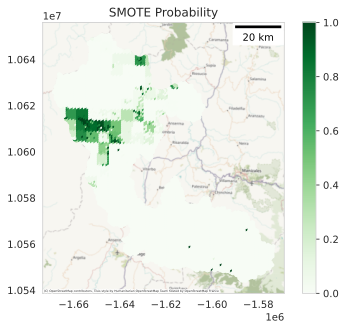

In [ ]:
# MAPS - PROBABILITY

# Ancho de la columna del documento en pulgadas
ancho_columna = 6.5314961

# Relación de aspecto
aspect_ratio = (4/3)

# Altura de la figura
altura_figura = ancho_columna/aspect_ratio

# Crear figura y ejes
fig, axis = plt.subplots(1,1,figsize=(ancho_columna, altura_figura), sharex = True, sharey = True)

axis.set_title('SMOTE Probability')
X.to_crs(epsg = 5382).plot(ax=axis, markersize=8, column='smote_probability', cmap='Greens', legend=True, vmin=0, vmax=1)
cx.add_basemap(ax=axis,crs=X.to_crs(epsg = 5382).crs,attribution_size=3)
axis.add_artist(ScaleBar(1))
plt.grid(False)

# save_fig("probability_lr",fig_extension="svg")
# save_fig("probability_lr",fig_extension="png")
plt.show()